# Running correlations beteween gene expression and OTU abundance


## Filtering lowly expressed genes and lowly abundant OTUs

 * Remove genes with less than one mapped read per million reads in at least 80% of samples ([Johnson and Krishnan, 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02568-9))
 * Retaining OTUs found at 0.001 relative abundance in at least 10% of the samples ([Priya et al 2022](https://www.nature.com/articles/s41564-022-01121-z))

### Filtering genes

Since RPKM will be used to filter out genes with low expression, it must be imported first:

In [1]:
import pandas as pd

kremling_expression_v5_day_rpkm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm.tsv',
                            sep='\t')
kremling_expression_v5_day_rpkm.set_index('Name', inplace=True)

kremling_expression_v5_night_rpkm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm.tsv',
                            sep='\t')
kremling_expression_v5_night_rpkm.set_index('Name', inplace=True)

These are the genes to be used in filtering steps:

In [2]:
genes_tokeep_day = kremling_expression_v5_day_rpkm[(kremling_expression_v5_day_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_day_rpkm.shape[1] * 0.8)].index
genes_tokeep_night = kremling_expression_v5_night_rpkm[(kremling_expression_v5_night_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_night_rpkm.shape[1] * 0.8)].index
print('Genes to keep in day:', len(genes_tokeep_day))
print('Genes to keep in night:', len(genes_tokeep_night))

Genes to keep in day: 13107
Genes to keep in night: 13630


Filtering RPKM:

In [3]:
kremling_expression_v5_day_rpkm_filtered = kremling_expression_v5_day_rpkm[(kremling_expression_v5_day_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_day_rpkm.shape[1] * 0.8)]
kremling_expression_v5_night_rpkm_filtered = kremling_expression_v5_night_rpkm[(kremling_expression_v5_night_rpkm > 1).sum(axis=1) >= (kremling_expression_v5_night_rpkm.shape[1] * 0.8)]

Importing the TPM, CPM, TMM, UQ, CTF and CUF matrices and filter genes:

In [4]:
kremling_expression_v5_day_tpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm.tsv',
                            sep='\t')
kremling_expression_v5_day_tpm.set_index('Name', inplace=True)

kremling_expression_v5_night_tpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm.set_index('Name', inplace=True)

kremling_expression_v5_day_tpm_filtered = kremling_expression_v5_day_tpm[kremling_expression_v5_day_tpm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tpm_filtered = kremling_expression_v5_night_tpm[kremling_expression_v5_night_tpm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm.tsv',
                            sep='\t')
kremling_expression_v5_day_cpm.set_index('Name', inplace=True)

kremling_expression_v5_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm.tsv',
                            sep='\t')
kremling_expression_v5_night_cpm.set_index('Name', inplace=True)

kremling_expression_v5_day_cpm_filtered = kremling_expression_v5_day_cpm[kremling_expression_v5_day_cpm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cpm_filtered = kremling_expression_v5_night_cpm[kremling_expression_v5_night_cpm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_tmm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm.tsv',
                            sep='\t')
kremling_expression_v5_day_tmm.set_index('Name', inplace=True)

kremling_expression_v5_night_tmm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm.tsv',
                            sep='\t')
kremling_expression_v5_night_tmm.set_index('Name', inplace=True)

kremling_expression_v5_day_tmm_filtered = kremling_expression_v5_day_tmm[kremling_expression_v5_day_tmm.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tmm_filtered = kremling_expression_v5_night_tmm[kremling_expression_v5_night_tmm.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_uq = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq.tsv',
                            sep='\t')
kremling_expression_v5_day_uq.set_index('Name', inplace=True)

kremling_expression_v5_night_uq = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq.tsv',
                            sep='\t')
kremling_expression_v5_night_uq.set_index('Name', inplace=True)

kremling_expression_v5_day_uq_filtered = kremling_expression_v5_day_uq[kremling_expression_v5_day_uq.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_uq_filtered = kremling_expression_v5_night_uq[kremling_expression_v5_night_uq.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_ctf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf.tsv',
                            sep='\t')
kremling_expression_v5_day_ctf.set_index('Name', inplace=True)

kremling_expression_v5_night_ctf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf.tsv',
                            sep='\t')
kremling_expression_v5_night_ctf.set_index('Name', inplace=True)

kremling_expression_v5_day_ctf_filtered = kremling_expression_v5_day_ctf[kremling_expression_v5_day_ctf.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_ctf_filtered = kremling_expression_v5_night_ctf[kremling_expression_v5_night_ctf.index.isin(genes_tokeep_night)]

kremling_expression_v5_day_cuf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf.tsv',
                            sep='\t')
kremling_expression_v5_day_cuf.set_index('Name', inplace=True)

kremling_expression_v5_night_cuf = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf.tsv',
                            sep='\t')
kremling_expression_v5_night_cuf.set_index('Name', inplace=True)

kremling_expression_v5_day_cuf_filtered = kremling_expression_v5_day_cuf[kremling_expression_v5_day_cuf.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cuf_filtered = kremling_expression_v5_night_cuf[kremling_expression_v5_night_cuf.index.isin(genes_tokeep_night)]

### Filtering OTUs

Since relative abundance will be used to filter out genes with low expression, it must be imported first:

In [5]:
otu_table_merged_day_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_day_relative_abund.tsv',
                            sep='\t')
otu_table_merged_day_relative_abund.set_index('OTU ID', inplace=True)

otu_table_merged_night_relative_abund = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_night_relative_abund.tsv',
                            sep='\t')
otu_table_merged_night_relative_abund.set_index('OTU ID', inplace=True)

In [6]:
otus_tokeep_day = otu_table_merged_day_relative_abund[(otu_table_merged_day_relative_abund > 0.001).sum(axis=1) >= (otu_table_merged_day_relative_abund.shape[1] * 0.1)].index
otus_tokeep_night = otu_table_merged_night_relative_abund[(otu_table_merged_night_relative_abund > 0.001).sum(axis=1) >= (otu_table_merged_night_relative_abund.shape[1] * 0.1)].index

Importing the OTU CPM matrices and filter OTUs:

In [7]:
otu_table_merged_day_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm.tsv',
                            sep='\t')
otu_table_merged_day_cpm.set_index('OTU ID', inplace=True)

otu_table_merged_night_cpm = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm.tsv',
                            sep='\t')
otu_table_merged_night_cpm.set_index('OTU ID', inplace=True)

OTU matrices are filtered based on relative abundance:

In [8]:
otu_table_merged_day_cpm_filtered = otu_table_merged_day_cpm[otu_table_merged_day_cpm.index.isin(otus_tokeep_day)]
otu_table_merged_night_cpm_filtered = otu_table_merged_night_cpm[otu_table_merged_night_cpm.index.isin(otus_tokeep_night)]

Importing the OTU counts matrices and filter OTUs:

In [9]:
otu_table_merged_counts = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
                            sep='\t')
otu_table_merged_counts.set_index('OTU ID', inplace=True)

OTU matrices are filtered based on relative abundance:

In [15]:
otu_table_merged_counts_day = otu_table_merged_counts[otu_table_merged_day_cpm_filtered.columns]
otu_table_merged_counts_night = otu_table_merged_counts[otu_table_merged_night_cpm_filtered.columns]

In [17]:
otu_table_merged_counts_day_filtered = otu_table_merged_counts_day[otu_table_merged_counts_day.index.isin(otus_tokeep_day)]
otu_table_merged_counts_night_filtered = otu_table_merged_counts_night[otu_table_merged_counts_night.index.isin(otus_tokeep_night)]

Exporting filtered count tables for day and night:

In [20]:
otu_table_merged_counts_day_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_day_filtered.tsv',
                            sep='\t')
otu_table_merged_counts_night_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_counts_night_filtered.tsv',
                            sep='\t')

## Filtering low variance (expression or OTUs)


[Priya et al 2022](https://www.nature.com/articles/s41564-022-01121-z) used 25% quantile as cutoff for gene expression analysis.

Filtering the Gene CPM, TPM, RPKM, TMM, UQ, CTF and CUF matrices:

In [26]:
import numpy as np

# Calculate the coefficient of variation for each row
kremling_expression_v5_day_tpm_filtered_cv = kremling_expression_v5_day_tpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tpm_filtered_cv = kremling_expression_v5_night_tpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tpm_filtered_cv_filtered = kremling_expression_v5_night_tpm_filtered.loc[kremling_expression_v5_night_tpm_filtered_cv[kremling_expression_v5_night_tpm_filtered_cv > kremling_expression_v5_night_tpm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_tpm_filtered_cv_filtered = kremling_expression_v5_day_tpm_filtered.loc[kremling_expression_v5_day_tpm_filtered_cv[kremling_expression_v5_day_tpm_filtered_cv > kremling_expression_v5_day_tpm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_cpm_filtered_cv = kremling_expression_v5_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cpm_filtered_cv = kremling_expression_v5_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cpm_filtered_cv_filtered = kremling_expression_v5_night_cpm_filtered.loc[kremling_expression_v5_night_cpm_filtered_cv[kremling_expression_v5_night_cpm_filtered_cv > kremling_expression_v5_night_cpm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_cpm_filtered_cv_filtered = kremling_expression_v5_day_cpm_filtered.loc[kremling_expression_v5_day_cpm_filtered_cv[kremling_expression_v5_day_cpm_filtered_cv > kremling_expression_v5_day_cpm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_rpkm_filtered_cv = kremling_expression_v5_day_rpkm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_rpkm_filtered_cv = kremling_expression_v5_night_rpkm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_rpkm_filtered_cv_filtered = kremling_expression_v5_night_rpkm_filtered.loc[kremling_expression_v5_night_rpkm_filtered_cv[kremling_expression_v5_night_rpkm_filtered_cv > kremling_expression_v5_night_rpkm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_rpkm_filtered_cv_filtered = kremling_expression_v5_day_rpkm_filtered.loc[kremling_expression_v5_day_rpkm_filtered_cv[kremling_expression_v5_day_rpkm_filtered_cv > kremling_expression_v5_day_rpkm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_tmm_filtered_cv = kremling_expression_v5_day_tmm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tmm_filtered_cv = kremling_expression_v5_night_tmm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_tmm_filtered_cv_filtered = kremling_expression_v5_night_tmm_filtered.loc[kremling_expression_v5_night_tmm_filtered_cv[kremling_expression_v5_night_tmm_filtered_cv > kremling_expression_v5_night_tmm_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_tmm_filtered_cv_filtered = kremling_expression_v5_day_tmm_filtered.loc[kremling_expression_v5_day_tmm_filtered_cv[kremling_expression_v5_day_tmm_filtered_cv > kremling_expression_v5_day_tmm_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_uq_filtered_cv = kremling_expression_v5_day_uq_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_uq_filtered_cv = kremling_expression_v5_night_uq_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_uq_filtered_cv_filtered = kremling_expression_v5_night_uq_filtered.loc[kremling_expression_v5_night_uq_filtered_cv[kremling_expression_v5_night_uq_filtered_cv > kremling_expression_v5_night_uq_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_uq_filtered_cv_filtered = kremling_expression_v5_day_uq_filtered.loc[kremling_expression_v5_day_uq_filtered_cv[kremling_expression_v5_day_uq_filtered_cv > kremling_expression_v5_day_uq_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_ctf_filtered_cv = kremling_expression_v5_day_ctf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_ctf_filtered_cv = kremling_expression_v5_night_ctf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_ctf_filtered_cv_filtered = kremling_expression_v5_night_ctf_filtered.loc[kremling_expression_v5_night_ctf_filtered_cv[kremling_expression_v5_night_ctf_filtered_cv > kremling_expression_v5_night_ctf_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_ctf_filtered_cv_filtered = kremling_expression_v5_day_ctf_filtered.loc[kremling_expression_v5_day_ctf_filtered_cv[kremling_expression_v5_day_ctf_filtered_cv > kremling_expression_v5_day_ctf_filtered_cv.quantile(q=0.25)].index]

kremling_expression_v5_day_cuf_filtered_cv = kremling_expression_v5_day_cuf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cuf_filtered_cv = kremling_expression_v5_night_cuf_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
kremling_expression_v5_night_cuf_filtered_cv_filtered = kremling_expression_v5_night_cuf_filtered.loc[kremling_expression_v5_night_cuf_filtered_cv[kremling_expression_v5_night_cuf_filtered_cv > kremling_expression_v5_night_cuf_filtered_cv.quantile(q=0.25)].index]
kremling_expression_v5_day_cuf_filtered_cv_filtered = kremling_expression_v5_day_cuf_filtered.loc[kremling_expression_v5_day_cuf_filtered_cv[kremling_expression_v5_day_cuf_filtered_cv > kremling_expression_v5_day_cuf_filtered_cv.quantile(q=0.25)].index]

Filtering the OTU CPM matrices:

In [27]:
# Calculate the coefficient of variation for each row
otu_table_merged_day_cpm_filtered_cv = otu_table_merged_day_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_night_cpm_filtered_cv = otu_table_merged_night_cpm_filtered.apply(lambda row: np.std(row) / np.mean(row), axis=1)
otu_table_merged_day_cpm_filtered_cv_filtered = otu_table_merged_day_cpm_filtered.loc[otu_table_merged_day_cpm_filtered_cv[otu_table_merged_day_cpm_filtered_cv > otu_table_merged_day_cpm_filtered_cv.quantile(q=0.25)].index]
otu_table_merged_night_cpm_filtered_cv_filtered = otu_table_merged_night_cpm_filtered.loc[otu_table_merged_night_cpm_filtered_cv[otu_table_merged_night_cpm_filtered_cv > otu_table_merged_day_cpm_filtered_cv.quantile(q=0.25)].index]

## Exporting all matrices after filtering

Matrices with all OTU and gene expression data, after filtering out low expressed/abundant and low variance were exported to be transformed using R libraries. Exporting:

In [28]:
# Exporting within sample normalized data after filtering
kremling_expression_v5_day_tpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_rpkm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_rpkm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')

# Exporting between sample normalized data after filtering
kremling_expression_v5_day_tmm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_tmm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_uq_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_uq_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_ctf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_ctf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_day_cuf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf_filtered_cv_filtered.tsv',
                            sep='\t')
kremling_expression_v5_night_cuf_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf_filtered_cv_filtered.tsv',
                            sep='\t')

# Exporting OTU data after filtering
otu_table_merged_day_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_day_cpm_filtered_cv_filtered.tsv',
                            sep='\t')
otu_table_merged_night_cpm_filtered_cv_filtered.to_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/otu_table_merged_night_cpm_filtered_cv_filtered.tsv',
                            sep='\t')

Exported OTU matrices (raw counts, CPM, relative abundance) after filtering low abundance and low variance data were transformed using different methods (VST, rlog, and asinh).

Importing matrices.

### asinh

In [ ]:
otu_table_merged_day_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_day_cpm_asinh.tsv',
                            sep='\t')
otu_table_merged_day_cpm_asinh.set_index('OTU ID', inplace=True)

otu_table_merged_night_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_d_n_otu_night_cpm_asinh.tsv',
                            sep='\t')
otu_table_merged_night_cpm_asinh.set_index('OTU ID', inplace=True)

### VST

### rlog

Exported matrices (RPKM, TPM, CPM, TMM, UQ, CTF and CUF) after removing low expressed genes and low variance, were transformed using different metods (VST, rlog, and asinh).

Importing the matrices after filtering and transformations.

### asinh

In [ ]:
#RPKM + asinh
kremling_expression_v5_day_rpkm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_rpkm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_rpkm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_rpkm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_rpkm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_rpkm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_rpkm_asinh_filtered = kremling_expression_v5_day_rpkm_asinh[kremling_expression_v5_day_rpkm_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_rpkm_asinh_filtered = kremling_expression_v5_night_rpkm_asinh[kremling_expression_v5_night_rpkm_asinh.index.isin(genes_tokeep_night)]

#TPM + asinh
kremling_expression_v5_day_tpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_tpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_tpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_tpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_tpm_asinh_filtered = kremling_expression_v5_day_tpm_asinh[kremling_expression_v5_day_tpm_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tpm_asinh_filtered = kremling_expression_v5_night_tpm_asinh[kremling_expression_v5_night_tpm_asinh.index.isin(genes_tokeep_night)]

#CPM + asinh
kremling_expression_v5_day_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_cpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_cpm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cpm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_cpm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_cpm_asinh_filtered = kremling_expression_v5_day_cpm_asinh[kremling_expression_v5_day_cpm_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cpm_asinh_filtered = kremling_expression_v5_night_cpm_asinh[kremling_expression_v5_night_cpm_asinh.index.isin(genes_tokeep_night)]

#TMM + asinh
kremling_expression_v5_day_tmm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_tmm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_tmm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_tmm_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_tmm_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_tmm_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_tmm_asinh_filtered = kremling_expression_v5_day_tmm_asinh[kremling_expression_v5_day_tmm_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_tmm_asinh_filtered = kremling_expression_v5_night_tmm_asinh[kremling_expression_v5_night_tmm_asinh.index.isin(genes_tokeep_night)]

#UQ + asinh
kremling_expression_v5_day_uq_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_uq_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_uq_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_uq_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_uq_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_uq_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_uq_asinh_filtered = kremling_expression_v5_day_uq_asinh[kremling_expression_v5_day_uq_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_uq_asinh_filtered = kremling_expression_v5_night_uq_asinh[kremling_expression_v5_night_uq_asinh.index.isin(genes_tokeep_night)]

#CTF + asinh
kremling_expression_v5_day_ctf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_ctf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_ctf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_ctf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_ctf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_ctf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_ctf_asinh_filtered = kremling_expression_v5_day_ctf_asinh[kremling_expression_v5_day_ctf_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_ctf_asinh_filtered = kremling_expression_v5_night_ctf_asinh[kremling_expression_v5_night_ctf_asinh.index.isin(genes_tokeep_night)]

#CUF + asinh
kremling_expression_v5_day_cuf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_day_cuf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_day_cuf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_night_cuf_asinh = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/quantification/kremling_expression_v5_night_cuf_asinh.tsv',
                            sep='\t')
kremling_expression_v5_night_cuf_asinh.set_index('Name', inplace=True)

kremling_expression_v5_day_cuf_asinh_filtered = kremling_expression_v5_day_cuf_asinh[kremling_expression_v5_day_cuf_asinh.index.isin(genes_tokeep_day)]
kremling_expression_v5_night_cuf_asinh_filtered = kremling_expression_v5_night_cuf_asinh[kremling_expression_v5_night_cuf_asinh.index.isin(genes_tokeep_night)]

### VST

### rlog

## Correlations - gene (no asinh) versus OTU (CPM)

In [176]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


### OTU (CPM) - Gene (CPM)

In [177]:
concat_df_night = pd.concat([kremling_expression_v5_night_cpm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cpm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_cpm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_cpm_filtered_cv_filtered.shape[0]

pairs_day_genecpm_otucpm = []
pairs_night_genecpm_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecpm_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecpm_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (TPM)

In [178]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_tpm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_tpm_filtered_cv_filtered.shape[0]

pairs_day_genetpm_otucpm = []
pairs_night_genetpm_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetpm_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetpm_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))


### OTU (CPM) - Gene (TMM)

In [179]:
concat_df_night = pd.concat([kremling_expression_v5_night_tmm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tmm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_tmm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_tmm_filtered_cv_filtered.shape[0]

pairs_day_genetmm_otucpm = []
pairs_night_genetmm_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetmm_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetmm_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (RPKM)

In [180]:
concat_df_night = pd.concat([kremling_expression_v5_night_rpkm_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_rpkm_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_rpkm_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_rpkm_filtered_cv_filtered.shape[0]

pairs_day_generpkm_otucpm = []
pairs_night_generpkm_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_generpkm_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_generpkm_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (UQ)

In [181]:
concat_df_night = pd.concat([kremling_expression_v5_night_uq_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_uq_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_uq_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_uq_filtered_cv_filtered.shape[0]

pairs_day_geneuq_otucpm = []
pairs_night_geneuq_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_geneuq_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_geneuq_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (CTF)

In [182]:
concat_df_night = pd.concat([kremling_expression_v5_night_ctf_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_ctf_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_ctf_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_ctf_filtered_cv_filtered.shape[0]

pairs_day_genectf_otucpm = []
pairs_night_genectf_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genectf_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genectf_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (CUF)

In [183]:
concat_df_night = pd.concat([kremling_expression_v5_night_cuf_filtered_cv_filtered, otu_table_merged_night_cpm_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cuf_filtered_cv_filtered, otu_table_merged_day_cpm_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.6)
shape_row_day = kremling_expression_v5_day_cuf_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.6)
shape_row_night = kremling_expression_v5_night_cuf_filtered_cv_filtered.shape[0]

pairs_day_genecuf_otucpm = []
pairs_night_genecuf_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecuf_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecuf_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

In [184]:
import upsetplot

from upsetplot import from_contents

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

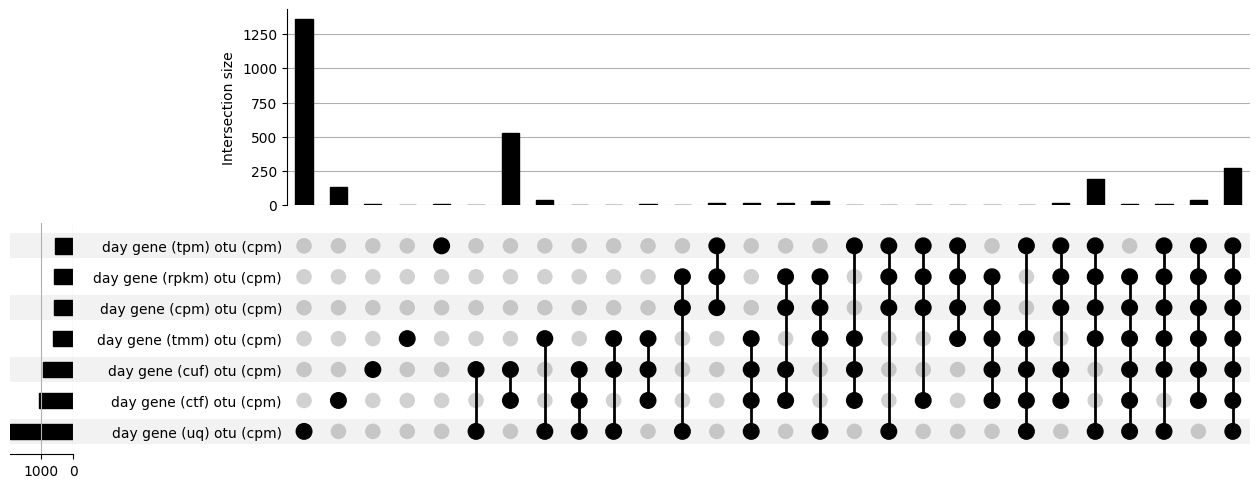

In [185]:
correlations_day = from_contents(
    {"day gene (cpm) otu (cpm)": pairs_day_genecpm_otucpm,
    "day gene (tpm) otu (cpm)": pairs_day_genetpm_otucpm,
    "day gene (tmm) otu (cpm)": pairs_day_genetmm_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_day_generpkm_otucpm,
    "day gene (uq) otu (cpm)": pairs_day_geneuq_otucpm,
    "day gene (ctf) otu (cpm)": pairs_day_genectf_otucpm,
    "day gene (cuf) otu (cpm)": pairs_day_genecuf_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_day, subset_size="count").plot()

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

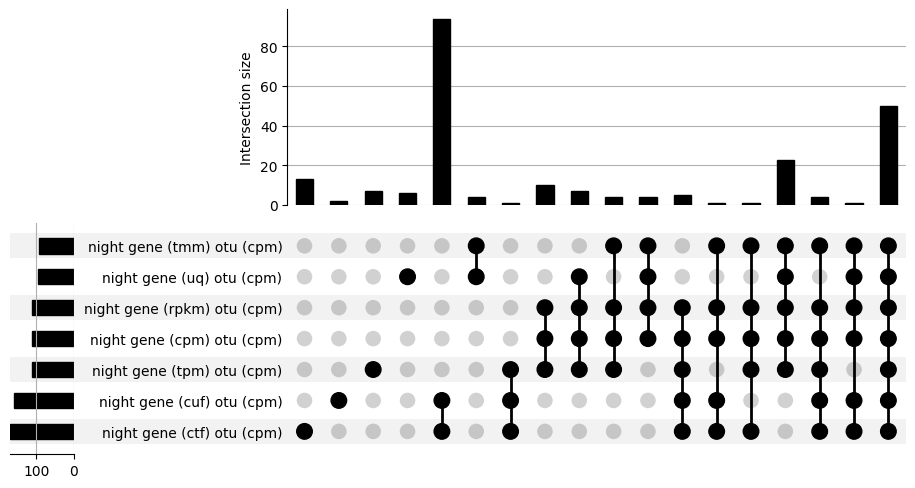

In [187]:
correlations_night = from_contents(
    {"night gene (cpm) otu (cpm)": pairs_night_genecpm_otucpm,
    "night gene (tpm) otu (cpm)": pairs_night_genetpm_otucpm,
    "night gene (tmm) otu (cpm)": pairs_night_genetmm_otucpm,
    "night gene (rpkm) otu (cpm)": pairs_night_generpkm_otucpm,
    "night gene (uq) otu (cpm)": pairs_night_geneuq_otucpm,
    "night gene (ctf) otu (cpm)": pairs_night_genectf_otucpm,
    "night gene (cuf) otu (cpm)": pairs_night_genecuf_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_night, subset_size="count").plot()

In [216]:
otucpm_severalgeneexpmethods_night = set(pairs_night_genecpm_otucpm).intersection(set(pairs_night_genetpm_otucpm),
                                             set(pairs_night_genetmm_otucpm),
                                             set(pairs_night_generpkm_otucpm),
                                             set(pairs_night_geneuq_otucpm),
                                             set(pairs_night_genectf_otucpm),
                                             set(pairs_night_genecuf_otucpm))

otucpm_severalgeneexpmethods_day = set(pairs_day_genecpm_otucpm).intersection(set(pairs_day_genetpm_otucpm),
                                             set(pairs_day_genetmm_otucpm),
                                             set(pairs_day_generpkm_otucpm),
                                             set(pairs_day_geneuq_otucpm),
                                             set(pairs_day_genectf_otucpm),
                                             set(pairs_day_genecuf_otucpm))

In [227]:
union_day_night = set(otucpm_severalgeneexpmethods_night).union(otucpm_severalgeneexpmethods_day)
intersection_day_night = set(otucpm_severalgeneexpmethods_night).intersection(otucpm_severalgeneexpmethods_day)

In [228]:
unique_day = set(otucpm_severalgeneexpmethods_night).difference(otucpm_severalgeneexpmethods_day)
unique_night = set(otucpm_severalgeneexpmethods_day).difference(otucpm_severalgeneexpmethods_night)

In [230]:
print(len(union_day_night),
      len(intersection_day_night),
      len(unique_day),
      len(unique_night))

309 11 39 259


In [234]:
unique_day

{('1080980', 'Zm00001eb366950_T001'),
 ('1084906', 'Zm00001eb057440_T003'),
 ('1113105', 'Zm00001eb313450_T001'),
 ('1133668', 'Zm00001eb366950_T001'),
 ('1147983', 'Zm00001eb313450_T001'),
 ('138177', 'Zm00001eb366950_T001'),
 ('1582784', 'Zm00001eb313450_T001'),
 ('1942231', 'Zm00001eb080150_T001'),
 ('235578', 'Zm00001eb167720_T001'),
 ('245552', 'Zm00001eb167720_T001'),
 ('252822', 'Zm00001eb080150_T001'),
 ('279699', 'Zm00001eb397500_T002'),
 ('4329518', 'Zm00001eb148930_T002'),
 ('4382894', 'Zm00001eb278340_T002'),
 ('541746', 'Zm00001eb366950_T001'),
 ('556913', 'Zm00001eb080150_T001'),
 ('589597', 'Zm00001eb167720_T001'),
 ('615153', 'Zm00001eb080150_T001'),
 ('615896', 'Zm00001eb080150_T001'),
 ('906905', 'Zm00001eb148930_T002'),
 ('994849', 'Zm00001eb331240_T001'),
 ('New.ReferenceOTU1110', 'Zm00001eb419390_T001'),
 ('New.ReferenceOTU1881', 'Zm00001eb080150_T001'),
 ('New.ReferenceOTU1901', 'Zm00001eb012470_T001'),
 ('New.ReferenceOTU2165', 'Zm00001eb331240_T001'),
 ('New.Ref

## Correlations - gene (asinh) versus OTU (CPM - asinh)

Initial tests with gene expression transformed using the asinh function did not return anything if correlations were made with untransformed OTU values (CPM without asinh). Therefore, I tested correlations after transforming all data equally (OTUs and Gene expressions were transformed)

### OTU (CPM) - Gene (CPM) - ASINH

In [188]:
concat_df_night = pd.concat([kremling_expression_v5_night_cpm_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cpm_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_cpm_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_cpm_asinh_filtered_cv_filtered.shape[0]

pairs_day_genecpmasinh_otucpm = []
pairs_night_genecpmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecpmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecpmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (TPM) - ASINH

In [189]:
concat_df_night = pd.concat([kremling_expression_v5_night_tpm_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tpm_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_tpm_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_tpm_asinh_filtered_cv_filtered.shape[0]

pairs_day_genetpmasinh_otucpm = []
pairs_night_genetpmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetpmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetpmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (RPKM) - ASINH

In [190]:
concat_df_night = pd.concat([kremling_expression_v5_night_rpkm_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_rpkm_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_rpkm_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_rpkm_asinh_filtered_cv_filtered.shape[0]

pairs_day_generpkmasinh_otucpm = []
pairs_night_generpkmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_generpkmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_generpkmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (TMM) - ASINH

In [191]:
concat_df_night = pd.concat([kremling_expression_v5_night_tmm_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_tmm_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_tmm_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_tmm_asinh_filtered_cv_filtered.shape[0]

pairs_day_genetmmasinh_otucpm = []
pairs_night_genetmmasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genetmmasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genetmmasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (UQ) - ASINH

In [192]:
concat_df_night = pd.concat([kremling_expression_v5_night_uq_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_uq_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_uq_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_uq_asinh_filtered_cv_filtered.shape[0]

pairs_day_geneuqasinh_otucpm = []
pairs_night_geneuqasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_geneuqasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_geneuqasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (CTF) - ASINH

In [193]:
concat_df_night = pd.concat([kremling_expression_v5_night_ctf_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_ctf_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_ctf_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_ctf_asinh_filtered_cv_filtered.shape[0]

pairs_day_genectfasinh_otucpm = []
pairs_night_genectfasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genectfasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genectfasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

### OTU (CPM) - Gene (CUF) - ASINH

In [194]:
concat_df_night = pd.concat([kremling_expression_v5_night_cuf_asinh_filtered_cv_filtered, otu_table_merged_night_cpm_asinh_filtered_cv_filtered], axis=0)
concat_df_day = pd.concat([kremling_expression_v5_day_cuf_asinh_filtered_cv_filtered, otu_table_merged_day_cpm_asinh_filtered_cv_filtered], axis=0)

concatenated_transposed_day = concat_df_day.transpose()
concatenated_transposed_night = concat_df_night.transpose()

cor_values_day = cor_full(concatenated_transposed_day)
cor_values_night = cor_full(concatenated_transposed_night)

true_positions_day = np.where(cor_values_day > 0.5)
shape_row_day = kremling_expression_v5_day_cuf_asinh_filtered_cv_filtered.shape[0]
true_positions_night = np.where(cor_values_night > 0.5)
shape_row_night = kremling_expression_v5_night_cuf_asinh_filtered_cv_filtered.shape[0]

pairs_day_genecufasinh_otucpm = []
pairs_night_genecufasinh_otucpm = []

for i in range(len(true_positions_day[0])):
    if (true_positions_day[1][i] > (shape_row_day - 1)) and (true_positions_day[0][i] < shape_row_day):
        pairs_day_genecufasinh_otucpm.append((str(cor_values_day.columns[true_positions_day[1][i]]),
              str(cor_values_day.index[true_positions_day[0][i]])))

for i in range(len(true_positions_night[0])):
    if (true_positions_night[1][i] > (shape_row_night - 1)) and (true_positions_night[0][i] < shape_row_night):
        pairs_night_genecufasinh_otucpm.append((str(cor_values_night.columns[true_positions_night[1][i]]),
              str(cor_values_night.index[true_positions_night[0][i]])))

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

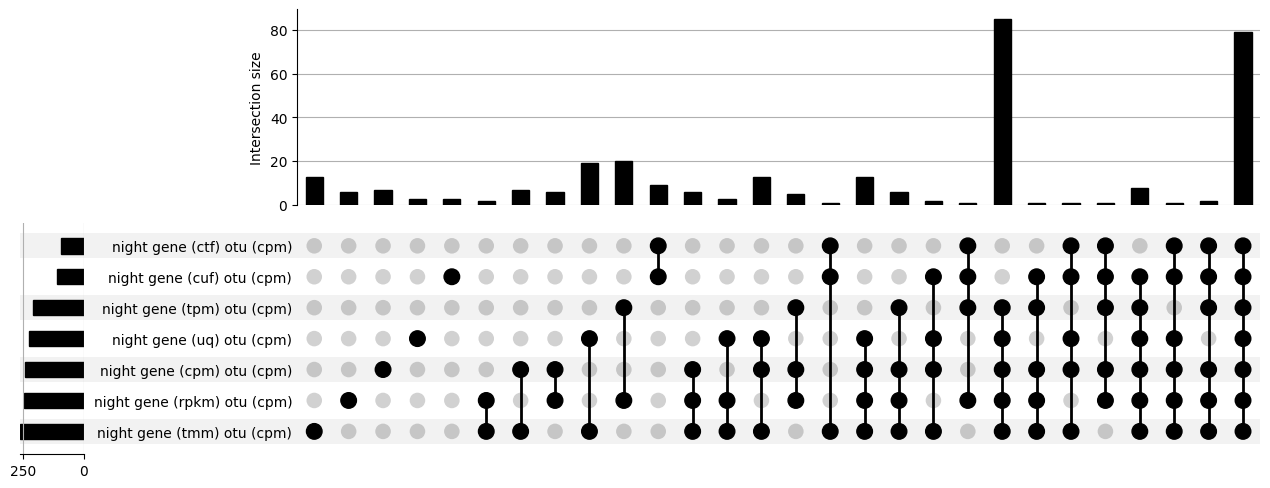

In [195]:
correlations_asinh_night = from_contents(
    {"night gene (cpm) otu (cpm)": pairs_night_genecpmasinh_otucpm,
    "night gene (tpm) otu (cpm)": pairs_night_genetpmasinh_otucpm,
    "night gene (tmm) otu (cpm)": pairs_night_genetmmasinh_otucpm,
    "night gene (rpkm) otu (cpm)": pairs_night_generpkmasinh_otucpm,
    "night gene (uq) otu (cpm)": pairs_night_geneuqasinh_otucpm,
    "night gene (ctf) otu (cpm)": pairs_night_genectfasinh_otucpm,
    "night gene (cuf) otu (cpm)": pairs_night_genecufasinh_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_night, subset_size="count").plot()

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

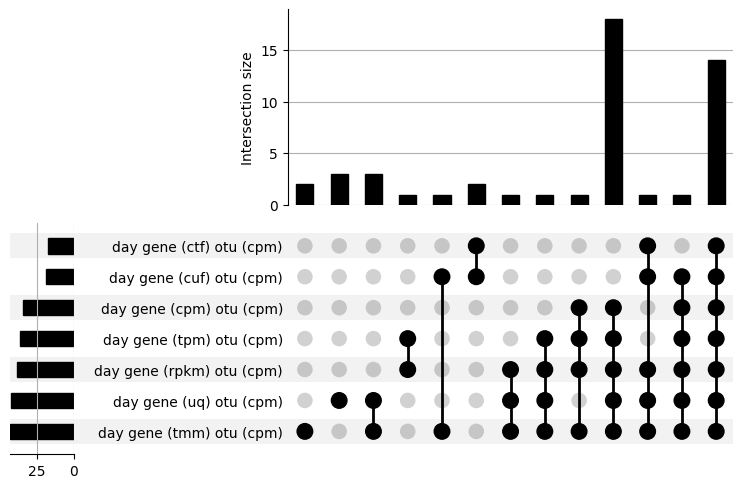

In [196]:
correlations_asinh_day = from_contents(
    {"day gene (cpm) otu (cpm)": pairs_day_genecpmasinh_otucpm,
    "day gene (tpm) otu (cpm)": pairs_day_genetpmasinh_otucpm,
    "day gene (tmm) otu (cpm)": pairs_day_genetmmasinh_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_day_generpkmasinh_otucpm,
    "day gene (uq) otu (cpm)": pairs_day_geneuqasinh_otucpm,
    "day gene (ctf) otu (cpm)": pairs_day_genectfasinh_otucpm,
    "day gene (cuf) otu (cpm)": pairs_day_genecufasinh_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_day, subset_size="count").plot()

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

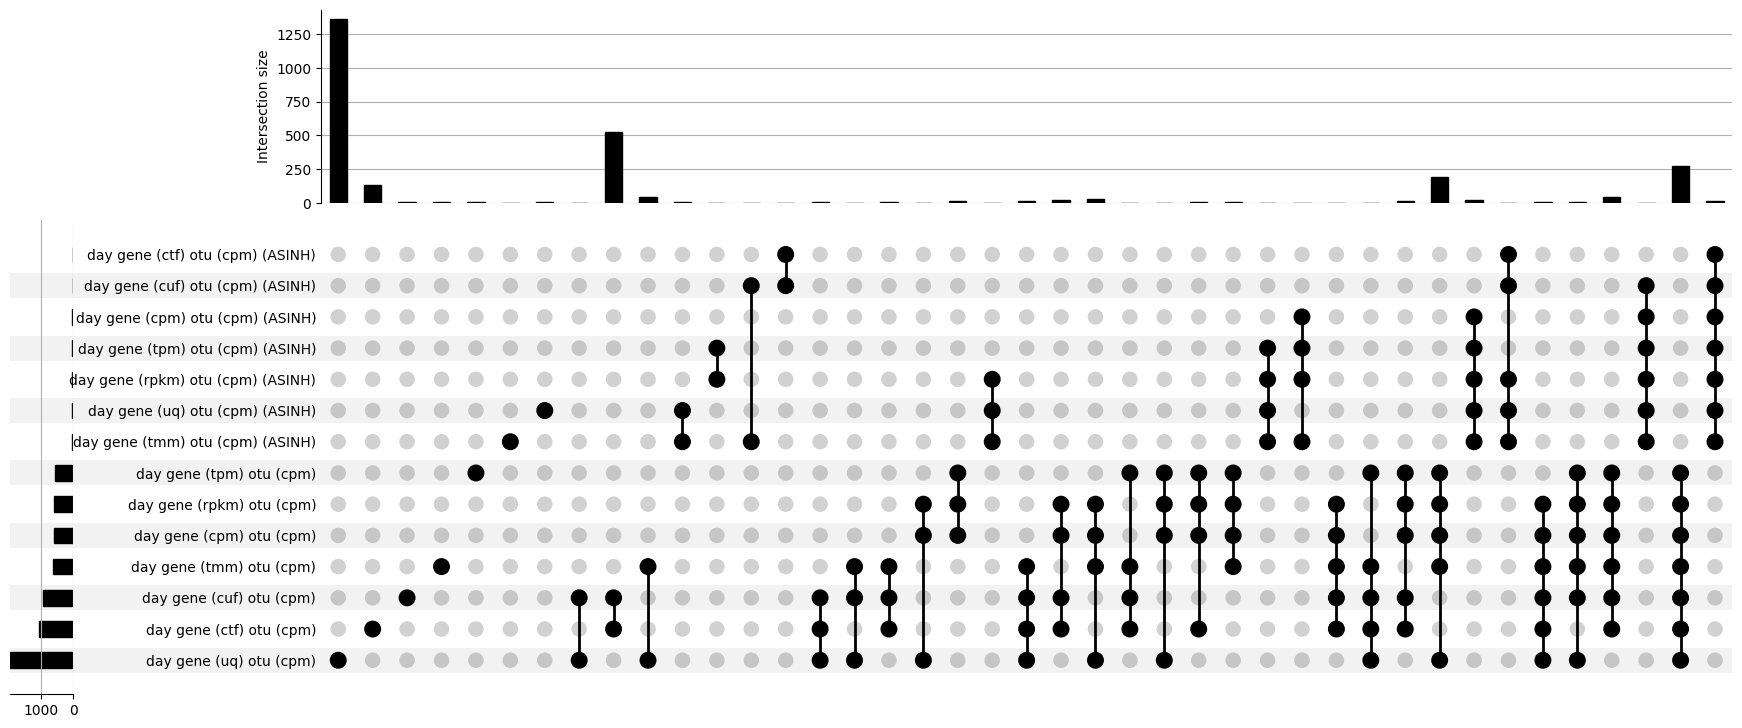

In [197]:
correlations_asinh_notasinh_day = from_contents(
    {"day gene (cpm) otu (cpm) (ASINH)": pairs_day_genecpmasinh_otucpm,
    "day gene (tpm) otu (cpm) (ASINH)": pairs_day_genetpmasinh_otucpm,
    "day gene (tmm) otu (cpm) (ASINH)": pairs_day_genetmmasinh_otucpm,
    "day gene (rpkm) otu (cpm) (ASINH)": pairs_day_generpkmasinh_otucpm,
    "day gene (uq) otu (cpm) (ASINH)": pairs_day_geneuqasinh_otucpm,
    "day gene (ctf) otu (cpm) (ASINH)": pairs_day_genectfasinh_otucpm,
    "day gene (cuf) otu (cpm) (ASINH)": pairs_day_genecufasinh_otucpm,
    "day gene (cpm) otu (cpm)": pairs_day_genecpm_otucpm,
    "day gene (tpm) otu (cpm)": pairs_day_genetpm_otucpm,
    "day gene (tmm) otu (cpm)": pairs_day_genetmm_otucpm,
    "day gene (rpkm) otu (cpm)": pairs_day_generpkm_otucpm,
    "day gene (uq) otu (cpm)": pairs_day_geneuq_otucpm,
    "day gene (ctf) otu (cpm)": pairs_day_genectf_otucpm,
    "day gene (cuf) otu (cpm)": pairs_day_genecuf_otucpm}
)

from upsetplot import UpSet

ax_dict = UpSet(correlations_asinh_notasinh_day, subset_size="count").plot()